# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things:

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_google_genai

In [2]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

## Messages as state

First, let's define some messages.

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash",api_key = google_api_key )
llm.invoke(messages)

AIMessage(content='That\'s great you\'re interested in ocean mammals! Whales are a huge group to start with, but there\'s a whole fascinating world beyond them.  To suggest others, let\'s break it down by group:\n\n**1. Marine Mammals closely related to land mammals:**\n\n* **Seals (Pinnipeds):**  These are a diverse group including:\n    * **True Seals (Phocidae):**  Lack external ear flaps, move on land by wriggling.  Examples: Harbor seals, Harp seals, Leopard seals.\n    * **Eared Seals (Otariidae):** Have external ear flaps, use their front flippers to "walk" on land. Examples: Sea lions, Fur seals.\n    * **Walruses (Odobenidae):**  Unique tusks, specialized for feeding on clams and other benthic invertebrates.\n\n* **Sea Otters (Mustelidae):**  The smallest marine mammal, incredibly intelligent and known for using tools.\n\n* **Polar Bears (Ursidae):**  While technically not entirely marine, they are highly adapted to Arctic sea ice and spend a significant portion of their lives

We can run our chat model in a simple graph with `MessagesState`.

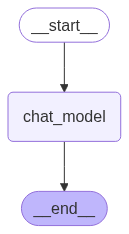

In [5]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Node
def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
output = graph.invoke({'messages': messages})
print(output)
print(output['messages'])

{'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='9056d0ca-f4ba-44be-bd8b-3e38a9fddfca'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='639512ed-8cff-466b-914d-206be3cc40e2'), AIMessage(content="That's great you're interested in ocean mammals! Whales are a fascinating group, but the ocean holds a diverse array of other amazing creatures.  To broaden your research, consider these groups:\n\n**1. Seals, Sea Lions, and Walruses (Pinnipeds):**\n\n* **Seals:**  These are generally characterized by their lack of external ear flaps, shorter flippers, and a more streamlined body for underwater agility.  There are many different species with varied habitats and behaviors.  Learn about harbor seals, elephant seals, leopard seals, etc.\n* **Sea Lions:**  Distinguished by their external ear flaps (pinnae

In [7]:
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Whales are a fascinating group, but the ocean holds a diverse array of other amazing creatures.  To broaden your research, consider these groups:

**1. Seals, Sea Lions, and Walruses (Pinnipeds):**

* **Seals:**  These are generally characterized by their lack of external ear flaps, shorter flippers, and a more streamlined body for underwater agility.  There are many different species with varied habitats and behaviors.  Learn about harbor seals, elephant seals, leopard seals, etc.
* **Sea Lions:**  Distinguished by their external ear flaps (pinnae), longer flipper

In [8]:
async for m in graph.astream_events({'messages': messages}, version="v2"): # The version argument is now correctly passed as a keyword argument.
      print(m)
      print("\n--------------\n")

      # on_chain_start = start of node's execution
      # on_chain_end = indicates completion of node's execution
      # on_chain_stream = Represent intermediate data or progress updates during a node's execution

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='9056d0ca-f4ba-44be-bd8b-3e38a9fddfca'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='639512ed-8cff-466b-914d-206be3cc40e2')]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '2aedc54b-35d8-4464-8999-4308979c242e', 'metadata': {}, 'parent_ids': []}

--------------

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='9056d0ca-f4ba-44be-bd8b-3e38a9fddfca'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='639512ed-8cff-466b-914d-206be3cc40e2')]}}, 'name': 'chat_model', 

## Reducer

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

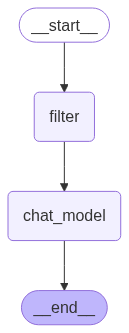

In [9]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState) -> MessagesState:
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    print("delete_messages",delete_messages)
    return {"messages": delete_messages}


def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

delete_messages [RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals!  Whales are a huge group, but there's a whole fascinating world beyond them.  To suggest further research, let's break it down by group:

**1. Marine Mammals Closely Related to Whales (Order Cetartiodactyla):**

* **Dolphins and Porpoises (Family Delphinidae & Phocoenidae):**  These are incredibly diverse, with many species exhibiting different behaviours, social structures, and adaptations.  

In [11]:
for m in output['messages']:
    print(m)

content='So you said you were researching ocean mammals?' additional_kwargs={} response_metadata={} name='Bot' id='3'
content='Yes, I know about whales. But what others should I learn about?' additional_kwargs={} response_metadata={} name='Lance' id='4'
content='That\'s great you\'re interested in ocean mammals!  Whales are a huge group, but there\'s a whole fascinating world beyond them.  To suggest further research, let\'s break it down by group:\n\n**1. Marine Mammals Closely Related to Whales (Order Cetartiodactyla):**\n\n* **Dolphins and Porpoises (Family Delphinidae & Phocoenidae):**  These are incredibly diverse, with many species exhibiting different behaviours, social structures, and adaptations.  Learn about their echolocation, social intelligence, and the threats they face.  Consider focusing on specific genera like *Orcinus* (killer whales), *Tursiops* (bottlenose dolphins), or *Stenella* (spotted dolphins).\n\n* **Porpoises (Family Phocoenidae):** These are often smaller a

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

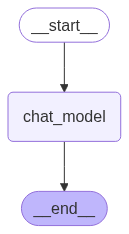

In [12]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [13]:
print(output['messages'][-1])

content='That\'s great you\'re interested in ocean mammals!  Whales are a huge group, but there\'s a whole fascinating world beyond them.  To suggest further research, let\'s break it down by group:\n\n**1. Marine Mammals Closely Related to Whales (Order Cetartiodactyla):**\n\n* **Dolphins and Porpoises (Family Delphinidae & Phocoenidae):**  These are incredibly diverse, with many species exhibiting different behaviours, social structures, and adaptations.  Learn about their echolocation, social intelligence, and the threats they face.  Consider focusing on specific genera like *Orcinus* (killer whales), *Tursiops* (bottlenose dolphins), or *Stenella* (spotted dolphins).\n\n* **Porpoises (Family Phocoenidae):** These are often smaller and less flashy than dolphins, but equally fascinating.  They tend to have more robust bodies and different echolocation clicks.\n\n**2. Carnivorous Marine Mammals (Order Carnivora):**\n\n* **Seals (Family Phocidae):** These are the "true seals," lacking 

In [14]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [17]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [18]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals!  Whales are a huge group, but there's a whole fascinating world beyond them.  To suggest further research, let's break it down by group:

**1. Marine Mammals Closely Related to Whales (Order Cetartiodactyla):**

* **Dolphins and Porpoises (Family Delphinidae & Phocoenidae):**  These are incredibly diverse, with many species exhibiting different behaviours, social structures,

In [19]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals!  Whales are a huge group, but there's a whole fascinating world beyond them.  To suggest further research, let's break it down by group:

**1. Marine Mammals Closely Related to Whales (Order Cetartiodactyla):**

* **Dolphins and Porpoises (Family Delphinidae & Phocoenidae):**  These are incredibly diverse, with many species exhibiting different behaviours, social structures,

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

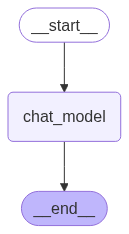

In [20]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last", #Retain the last messages upto the token limit
            token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key = google_api_key),
            allow_partial=False, #If adding one full message would exceed the token limit, it skips that message entirely rather than including just part of it.
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
print(output['messages'][-1])

content='Narwhals ( *Monodon monoceros*) are truly fascinating creatures, often called "unicorns of the sea" due to their prominent tusk.  Here\'s a breakdown of what makes them unique:\n\n**The Tusk:**\n\n* **Not just a tooth:**  The tusk is actually an elongated left incisor tooth that grows through the upper lip of the male narwhal.  Females sometimes develop a small tusk, but it rarely protrudes.\n* **Sensory organ:**  Scientists believe the tusk is highly sensitive, containing millions of nerve endings.  It\'s theorized to be used for sensing changes in water pressure, temperature, and salinity, helping the narwhal navigate and find prey in icy waters.  It may also play a role in social interactions.\n* **Show of strength:**  The size and shape of the tusk can be an indicator of the narwhal\'s age and social status, potentially influencing mating success.\n\n**Physical Characteristics:**\n\n* **Appearance:**  They have a streamlined, torpedo-shaped body, perfectly adapted for navi

In [23]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [25]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key = google_api_key ),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [29]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})
for m in messages_out_trim['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals!  Whales are a huge group, but there's a whole fascinating world beyond them.  To suggest further research, let's break it down by group:

**1. Marine Mammals Closely Related to Whales (Order Cetartiodactyla):**

* **Dolphins and Porpoises (Family Delphinidae & Phocoenidae):**  These are incredibly diverse, with many species exhibiting different behaviours, social structures,

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r

Let’s make this very concrete with an example. Trimming is about **counting tokens**, not just counting messages — so it’s smarter than just slicing the last N messages.

---

## Imagine this conversation history:

```
1. User: Hi, can you explain quantum computing in simple terms?
2. AI: Sure! Quantum computing uses qubits that can be 0 and 1 at the same time...
3. User: That’s cool. Can you also compare it to classical computing?
4. AI: Classical computers use bits that are either 0 or 1...
5. User: Great! Now give me a 500-word essay about quantum entanglement.
6. AI: [long 400-token essay...]
7. User: Now explain quantum teleportation in 200 words.
```

---

## If you just slice messages with `[-3:]`

* You’d get **messages 5, 6, and 7** — but message 6 alone might already be 400 tokens.
* So you could **accidentally exceed your 100-token limit** (if your LLM only accepts 100 tokens).

---

## If you use `trim_messages(max_tokens=100, strategy="last")`

* It **measures the token size of every message**.
* Then it **starts adding messages from the end** (most recent first) until it hits 100 tokens.
* In this example:

  * Message 7 might be \~30 tokens → **included**
  * Message 6 is 400 tokens → **too big, skipped entirely** (because `allow_partial=False`)
  * Message 5 might be 20 tokens → **included**
  * Message 4 might be 25 tokens → **included**
  * Total now = 30+20+25 = 75 tokens → still under 100
  * Next would be message 3 (\~15 tokens) → **included**
  * Total = \~90 tokens → stop before hitting 100

### **Result after trimming:**

```
3. User: That’s cool. Can you also compare it to classical computing?
4. AI: Classical computers use bits that are either 0 or 1...
5. User: Great! Now give me a 500-word essay about quantum entanglement.
7. User: Now explain quantum teleportation in 200 words.
```

Notice:

* **Message 6 was dropped entirely** because it was too large.
* **Older messages were removed first** (1 and 2 are gone).
* The **conversation stays within 100 tokens**, guaranteed.

---

## Why is this powerful?

* You **never blow past the LLM context limit**, even if a single message is huge.
* The model **still sees the latest context**, but big out-of-budget messages get skipped cleanly.
* This is much safer than just picking the last N messages blindly.

---
